# N08: BI DEVELOPMENT - Building The Reporting Schema
 
## Notebook Description

In this notebook, an analytical and reporting system will be developed to inform future business decisions. As a first step, the following data visualizations will be created:

1. **Displaying the top 10 airports by departures**, also displaying the number of arrivals in a table format
2. **Displaying the top 10 flight routes**, with the lowest percentage of delays in a table format
3. **Displaying a comparison of 2019 and 2020**, in the form of a bar chart
   - Monthly comparison
   - Weekly day-by-day comparison
4. **Displaying day-by-day data**, in the form of a time series

The report will be structured into three sections: `TOP Report`, `Comparison`, and `Day-by-Day Reliability`.

By utilizing the previously predefined database views (N05_Data_Engineering_Building_Reporting_Schema), the need for additional data processing and handling is eliminated. Additionally, technical aspects such as row counts, joins, and filters are offloaded to the database, reducing the volume of data exchanged between the service and the database.

####
## Notebook Configuration

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Libraries import</p>

In [1]:
from psycopg2 import connect
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import dash
from dash import dash_table, dcc, html
from dash.dependencies import Input, Output, State

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Connecting to the database</p>

In [2]:
cnx = connect(user='postgres_user', password='coderslab', host='localhost', database='airlines')
cursor = cnx.cursor()

###
## Displaying The Top 10 Reliable Airports By Departure

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Defining SQL query</p>

In [3]:
sql_query_top_10_airports = """SELECT 
                                    al.display_airport_name AS Airport, 
                                    f.year AS Year, 
                                    ROUND(CAST(SUM(f.nas_delay) AS numeric) / CAST(COUNT(*) AS numeric), 2) AS Reliability, 
                                    DENSE_RANK() OVER (ORDER BY ROUND(CAST(SUM(f.nas_delay) AS numeric) / CAST(COUNT(*) AS numeric), 2) DESC) AS Rank 
                                FROM 
                                    flight AS f
                                LEFT JOIN 
                                    airport_list AS al ON f.origin_airport_id = al.origin_airport_id
                                GROUP BY 
                                    al.display_airport_name, 
                                    f.year
                                HAVING 
                                    COUNT(*) > 10000
                                ORDER BY 
                                    Reliability DESC
                                LIMIT 10
                                """

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Fetching data from the 'reporting.top_reliability_roads' view</p>

In [4]:
cursor.execute(sql_query_top_10_airports)
top_airports_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
top_airports_df = pd.DataFrame(top_airports_data, columns=columns)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>
Changing the number format in the 'reliability' column to a percentage format</p>

In [5]:
top_airports_df['reliability'] = top_airports_df['reliability'].apply(lambda x: '{:.2%}'.format(x / 100))

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Renaming the columns</p>

In [6]:
top_airports_df = top_airports_df.rename(columns={'airport': 'departure airport name'})

In [7]:
top_airports_df

,departure airport name,year,reliability,rank
0,Portland International Jetport,2019,5.82%,1
1,Palm Beach International,2019,5.49%,2
2,Northwest Arkansas Regional,2019,5.17%,3
3,Minneapolis-St Paul International,2019,5.09%,4
4,Newark Liberty International,2019,4.92%,5
5,John F. Kennedy International,2019,4.84%,6
6,Rochester Monroe County,2019,4.81%,7
7,Richmond International,2019,4.69%,8
8,LaGuardia,2019,4.64%,9
9,Cincinnati/Northern Kentucky International,2019,4.60%,10


###
## Displaying The Top 10 Most Reliable Routes

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Defining SQL query</p>

In [8]:
sql_query_top_10_routes = """SELECT 
                                origin_airport_name AS Origin, 
                                dest_airport_name AS Destination, 
                                year AS Year, 
                                reliability AS Reliability, 
                                nb AS Rank 
                            FROM reporting.top_reliability_roads 
                            ORDER BY nb 
                            LIMIT 10
                            """

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Fetching data from the 'reporting.top_reliability_roads' view</p>

In [9]:
cursor.execute(sql_query_top_10_routes)
top_routes_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
top_routes_df = pd.DataFrame(top_routes_data, columns=columns)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>
Changing the number format in the 'reliability' column to a percentage format</p>

In [10]:
top_routes_df['reliability'] = top_routes_df['reliability'].apply(lambda x: '{:.2%}'.format(x / 100))

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Renaming the columns</p>

In [11]:
top_routes_df = top_routes_df.rename(columns={'origin': 'origin airport', 'destination': 'destination airport'})

In [12]:
top_routes_df

,origin airport,destination airport,year,reliability,rank
0,Chicago O'Hare International,LaGuardia,2019,11.09%,1
1,LaGuardia,Chicago O'Hare International,2019,9.13%,2
2,Logan International,LaGuardia,2019,8.38%,3
3,Los Angeles International,San Francisco International,2019,8.00%,4
4,LaGuardia,Logan International,2019,5.66%,5
5,Los Angeles International,John F. Kennedy International,2019,5.09%,6
6,John F. Kennedy International,Los Angeles International,2019,4.24%,7
7,San Francisco International,Los Angeles International,2019,2.94%,8
8,McCarran International,Los Angeles International,2019,2.26%,9
9,Los Angeles International,McCarran International,2019,2.14%,10


###
## Displaying a Comparison Of 2019 And 2020

#### Month-to-Month

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Defining SQL query</p>

In [13]:
sql_query_mom = "SELECT * FROM reporting.month_to_month_comparision"

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Fetching data from the for 'reporting.month_to_month_comparision' view</p>

In [14]:
cursor.execute(sql_query_mom)
mom_comparision_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
mom_comparision_df = pd.DataFrame(mom_comparision_data, columns=columns)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>
Transforming the results into the format expected by a bar chart</p>

In [15]:
mom_comparision_df['reliability'] = mom_comparision_df['reliability'].astype(float)

In [16]:
mom_comparision_to_plot_df = mom_comparision_df.pivot(index='month', columns='year', values='reliability')

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Drawing a bar chart</p>

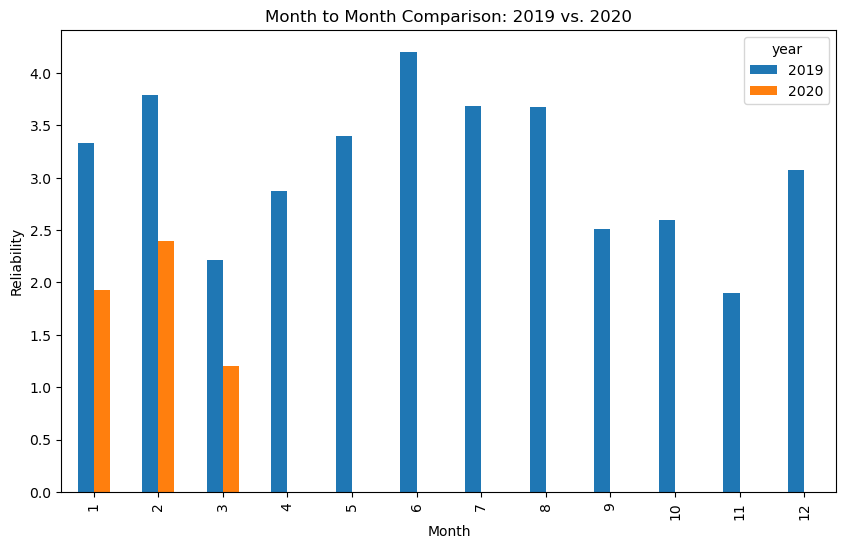

In [17]:
mom_comparision_fig = mom_comparision_to_plot_df.plot(kind='bar', figsize=(10, 6))
mom_comparision_fig.set_xlabel('Month')
mom_comparision_fig.set_ylabel('Reliability')
mom_comparision_fig.set_title('Month to Month Comparison: 2019 vs. 2020')
plt.show()

### Key Observations

##### General Comparison (2019 vs. 2020):
<li>Reliability in 2019 is consistently higher across all months compared to 2020, indicating that 2019 had a more stable or efficient operational environment.</li>
<li>2020 shows a noticeable decline in reliability across most months, which could be attributed to disruptions like the COVID-19 pandemic or other significant operational challenges.</li>

##### 2020 Monthly Trends:
<li>Reliability in 2020 is relatively higher in January and February, aligning with the pre-pandemic period where operations might not yet have been affected.</li>
<li>Starting in March 2020, reliability drops significantly, which is likely linked to the onset of the COVID-19 pandemic and its associated disruptions (e.g., reduced staffing, route adjustments, or increased cancellations).</li>

##### 2019 Stability:
<li>Reliability remains relatively stable throughout 2019, suggesting that the operations during that year were largely unaffected by major external disruptions.</li>
<li>Some variations across months are visible, but the overall trend is consistent with reliable performance.</li>

##### Impact of Global Events:
<li>The drastic drop in reliability in 2020 likely reflects the challenges brought by the pandemic, including flight cancellations, schedule disruptions, and reduced airline capacity.</li>
<br>
The graph highlights the significant decline in reliability in 2020 compared to 2019, likely due to the COVID-19 pandemic's impact on global aviation operations. While 2019 demonstrates a relatively stable performance across all months, 2020 exhibits a sharp decline starting in March, with the lowest reliability observed in the subsequent months. These findings emphasize the operational challenges airlines faced during 2020 and the drastic impact of global events on reliability metrics.

###
#### Day-to-Day

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Defining SQL query</p>

In [18]:
sql_query_dod = "SELECT * FROM reporting.day_to_day_comparision"

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Fetching data from the for 'reporting.day_to_day_comparision' view</p>

In [19]:
cursor.execute(sql_query_dod)
dod_comparision_data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
dod_comparision_df = pd.DataFrame(dod_comparision_data, columns=columns)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>
Transforming the results into the format expected by a bar chart</p>

In [20]:
dod_comparision_to_plot_df = dod_comparision_df.pivot(index='day_of_week', columns='year', values='flights_amount')

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Drawing a bar chart</p>

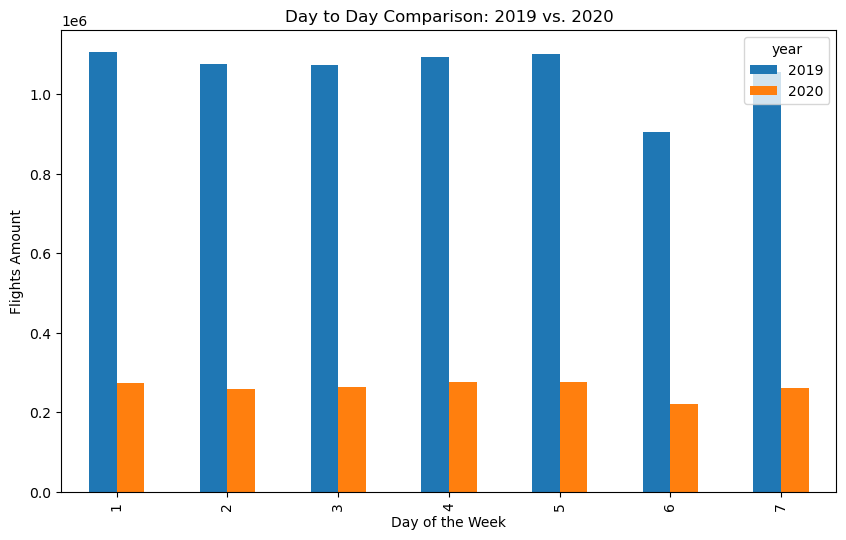

In [21]:
dod_comparision_fig = dod_comparision_to_plot_df.plot(kind='bar', figsize=(10, 6))
dod_comparision_fig.set_xlabel('Day of the Week')
dod_comparision_fig.set_ylabel('Flights Amount')
dod_comparision_fig.set_title('Day to Day Comparison: 2019 vs. 2020')
plt.show()

### Key Observations

##### Comparison Between 2019 and 2020
<li>2019 consistently has a much higher flight volume across all days of the week compared to 2020. This indicates that flight operations were substantially reduced in 2020.</li>
<li>The significant drop in flight amounts in 2020 likely reflects the impact of the COVID-19 pandemic, which led to reduced travel demand and flight cancellations globally.</li>

##### Consistency Across Days
<li>In both years, flight operations are relatively consistent across the days of the week, with no significant variation in flight volumes for specific days.</li>
<li>This suggests that flight schedules were evenly distributed throughout the week in both years, regardless of the overall reduction in 2020.</li>

##### Magnitude of Reduction in 2020
<li>Flight amounts in 2020 are approximately one-fifth of the levels seen in 2019 across all days. This reflects the severity of the operational challenges faced by airlines during the pandemic.</li>

##### Operational Impact of the Pandemic
<li>The sharp reduction in flight volume highlights the massive disruption to the aviation industry in 2020, affecting all days of the week equally.</li>

<br>
The graph illustrates the drastic decline in flight operations in 2020 compared to 2019, likely caused by the COVID-19 pandemic. While the total flight amount was significantly lower in 2020, the distribution of flights across the days of the week remained consistent, reflecting a uniform impact of the pandemic on aviation schedules. These findings underscore the extensive challenges faced by the airline industry during this period.

###
## Displaying `day-by-day` Reliability Data As Time Series

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Defining SQL query</p>

In [22]:
sql_query_dbd_reliability_2019 = "SELECT * FROM reporting.day_by_day_reliability WHERE year = 2019"
sql_query_dbd_reliability_2020 = "SELECT * FROM reporting.day_by_day_reliability WHERE year = 2020"

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Fetching data from the for 'reporting.day_by_day_reliability' view</p>

In [23]:
# fetch data for 2019
cursor.execute(sql_query_dbd_reliability_2019)
dbd_reliability_data_2019 = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df_2019 = pd.DataFrame(dbd_reliability_data_2019, columns=columns)

# fetch data for 2020
cursor.execute(sql_query_dbd_reliability_2020)
dbd_reliability_data_2020 = cursor.fetchall()
df_2020 = pd.DataFrame(dbd_reliability_data_2020, columns=columns)

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Plotting a time series chart</p>

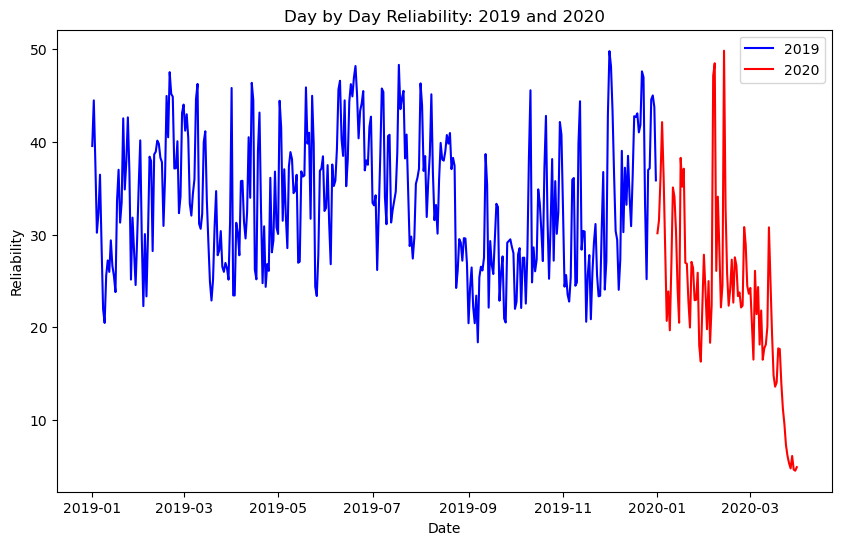

In [24]:
dbd_reliability_fig = plt.figure(figsize=(10, 6))
plt.plot(df_2019['date'], df_2019['reliability'], color='blue', label='2019')
plt.plot(df_2020['date'], df_2020['reliability'], color='red', label='2020')
plt.xlabel('Date')
plt.ylabel('Reliability')
plt.title('Day by Day Reliability: 2019 and 2020')
plt.legend()
plt.show()

### Key Observations

##### 2019 Reliability Trends
<li>Reliability in 2019 remains consistently high throughout the year, with fluctuations that likely reflect normal operational variations and seasonal factors.</li>
<li>There is no major decline or significant disruption in reliability for 2019, suggesting a relatively stable year for flight operations.</li>

##### 2020 Reliability Trends
<li>Reliability in 2020 starts at similar levels to 2019 in early January and February.</li>
<li>A sharp decline in reliability begins in March 2020, which coincides with the onset of the COVID-19 pandemic. This suggests a strong correlation between the pandemic and the operational challenges faced by the airline industry, such as flight cancellations, route disruptions, and reduced capacity.</li>

##### Impact of the Pandemic
<li>The dramatic drop in reliability in 2020 indicates that the pandemic caused widespread disruptions to flight operations, severely impacting the aviation sector by March 2020.</li>

##### Comparison Between Years
<li>2019 exhibits a relatively steady reliability pattern, reflecting typical airline operations unaffected by major external disruptions.
<li>2020 shows a progressive and severe decline in reliability, with levels falling significantly below 2019 levels as the pandemic took hold.</li>

<br>
The graph highlights the stability of flight operations in 2019 compared to the sharp decline in reliability in early 2020, driven by the COVID-19 pandemic. While the beginning of 2020 mirrors the reliability patterns of 2019, March 2020 marks a critical turning point, with reliability dropping drastically as the aviation industry faced unprecedented challenges. This underscores the severe operational disruptions caused by global events like the pandemic.

###
## DASH Display

### Constructing Views and Layouts With Retrieved Data

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating a Plotly-compatible figure for the Day-to-Day comparison</p>

In [25]:
dod_comparision_fig = {
    'data': [
        {'x': dod_comparision_to_plot_df.index, 'y': dod_comparision_to_plot_df[2019], 'type': 'bar', 'name': '2019'},
        {'x': dod_comparision_to_plot_df.index, 'y': dod_comparision_to_plot_df[2020], 'type': 'bar', 'name': '2020'},
    ],
    'layout': {
        'title': 'Day-to-Day Comparison: 2019 vs. 2020',
        'xaxis': {'title': 'Day of Week'},
        'yaxis': {'title': 'Flights Amount'},
    }
}

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating a Plotly-compatible figure for the Month-to-Month comparison</p>

In [26]:
mom_comparision_fig = {
    'data': [
        {'x': mom_comparision_to_plot_df.index, 'y': mom_comparision_to_plot_df[2019], 'type': 'bar', 'name': '2019'},
        {'x': mom_comparision_to_plot_df.index, 'y': mom_comparision_to_plot_df[2020], 'type': 'bar', 'name': '2020'},
    ],
    'layout': {
        'title': 'Month-to-Month Comparison: 2019 vs. 2020',
        'xaxis': {'title': 'Month'},
        'yaxis': {'title': 'Reliability'},
    }
}


<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Transforming the 'day-by-day' reliability time-series plot into a BytesIO object and encoding it in base64</p>

In [27]:
img = BytesIO()
dbd_reliability_fig.savefig(img, format='png')
img.seek(0)
dbd_reliability_fig_base64 = base64.b64encode(img.getvalue()).decode('utf-8')
img.close()

###
### DASH Display Configuration

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Creating the layout and navigation for the DASH display</p>

In [28]:
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Location(id='url', refresh=False),
    html.Button("Go to TOP 10 Airports", id="btn-top-ten-airports", n_clicks=0),
    html.Button("Go to TOP 10 Routes", id="btn-top-ten-routes", n_clicks=0),
    html.Button("Go to Comparision", id="btn-comparision", n_clicks=0),
    html.Button("Go to Day by Day Reporting", id="btn-day-by-day", n_clicks=0),
    html.Div(id='page-content')
])

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Configuring the display's navigation</p>

In [29]:
@app.callback(Output('url', 'pathname'),
              [Input('btn-top-ten-airports', 'n_clicks'),
               Input('btn-top-ten-routes', 'n_clicks'),
                Input('btn-comparision', 'n_clicks'),
               Input('btn-day-by-day', 'n_clicks')],
              [State('url', 'pathname')])
def update_url(btn_top_ten_airports_clicks, btn_top_ten_routes_clicks, btn_comparision_clicks, btn_day_by_day_clicks, current_path):
    ctx = dash.callback_context
    if not ctx.triggered:
        return current_path
    else:
        button_id = ctx.triggered[0]["prop_id"].split(".")[0]
        if button_id == "btn-top-ten-airports":
            return "/"
        elif button_id == "btn-top-ten-routes":
            return "/top_ten_routes"
        elif button_id == "btn-comparision":
            return "/comparision_reporting"
        elif button_id == "btn-day-by-day":
            return "/day_by_day_reporting"
        else:
            return current_path

In [30]:
@app.callback(Output('page-content', 'children'),
              [Input('url', 'pathname')])
def display_page(pathname):
    if pathname == '/':
        return html.Div([html.H3("TOP 10 Most Reliable Airports By Departure"), 
                         dash_table.DataTable(
            id='top-airports-table',
            columns=[{"name": i, "id": i} for i in top_airports_df.columns],
            data=top_airports_df.to_dict('records')
        )])
    elif pathname == '/top_ten_routes':
        return html.Div([html.H3("TOP 10 Most Reliable Routes"), 
                         dash_table.DataTable(
            id='top-routes-table',
            columns=[{"name": j, "id": j} for j in top_routes_df.columns],
            data=top_routes_df.to_dict('records')
        )])    
    elif pathname == '/comparision_reporting':
        return html.Div([dcc.Graph(figure=mom_comparision_fig),
                         dcc.Graph(figure=dod_comparision_fig)])
    elif pathname == '/day_by_day_reporting':
        return html.Div(html.Img(src=f"data:image/png;base64,{dbd_reliability_fig_base64}"))
    else:
        return html.Div([html.H3("404: Page not found")])

<p style='background-color: #FFFFE0; margin-top:20px; padding:5px 15px; font-weight: 500'>Starting the DASH display</p>

In [31]:
if __name__ == '__main__':
    app.run_server(debug=False)